# Santiago weather analysis

In [4]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.figsize'] = 15, 5


import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm

In [5]:
# read processed before dataset
df = pd.read_csv("Santiago.csv", index_col=0)
df.set_index([pd.to_datetime(df.index)], inplace=True)

In [6]:
df

,TEMP,DEWP,SLP,STP,VISIB,WDSP,PRCP
1990-01-01,44.857143,42.728571,9999.900000,999.900000,5.400000,6.042857,0.268571
1990-01-08,43.485714,37.042857,9999.900000,999.900000,5.671429,3.071429,0.002857
1990-01-15,44.285714,38.557143,9999.900000,999.900000,5.028571,3.914286,0.004286
1990-01-22,47.500000,45.485714,9999.900000,999.900000,5.357143,9.385714,0.375714
1990-02-01,49.657143,45.071429,9999.900000,999.900000,5.657143,12.257143,0.500000
...,...,...,...,...,...,...,...
2019-10-22,55.457143,51.228571,9999.900000,999.900000,6.042857,5.985714,0.098571
2019-11-01,52.600000,51.342857,9999.900000,999.900000,5.014286,7.428571,0.540000
2019-11-08,47.757143,45.671429,9999.900000,999.900000,4.885714,5.785714,0.437143
2019-11-15,43.775000,41.925000,9999.900000,999.900000,5.425000,4.075000,0.427500


Our weather data contains measures of temperature, dew point, sea level pressure, station pressure, visibility, wind speed and precipitation amount. Here I will analyse each of this measurment.

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

# decompose time series data to trend, season and residuals
def decompose(ts, freq):
    decomposition = seasonal_decompose(ts, freq=freq)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    residual.dropna(inplace=True);
    
    # Original
    plt.subplot(411)
    plt.plot(ts, label='Original')
    plt.legend(loc='upper left')
    
    # Trend
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    
    # Seasonality
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonality')
    plt.legend(loc='upper left')
    
    # Resudials
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    return (residual, trend, seasonal)

## Temperature

In [8]:
temp = df.TEMP
temp

1990-01-01    44.857143
1990-01-08    43.485714
1990-01-15    44.285714
1990-01-22    47.500000
1990-02-01    49.657143
                ...    
2019-10-22    55.457143
2019-11-01    52.600000
2019-11-08    47.757143
2019-11-15    43.775000
2019-11-22    47.202956
Name: TEMP, Length: 1436, dtype: float64


To predict weather data for 2019 year, we will use ARIMA model.To do that we need to decompose data to make our time series data stationary - extract trend and season from it.


__Decomposing__

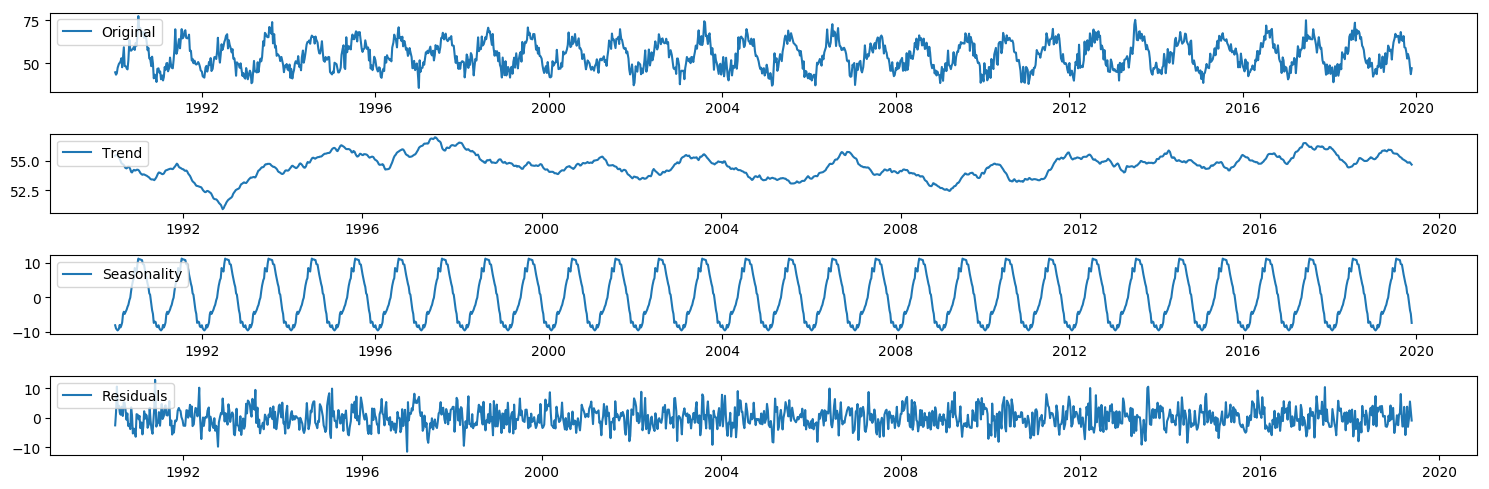

In [9]:
# 48, cause there are 4 weeks for each month, and there are 12 month, so period should be 4*12 = 48
temp_results = decompose(temp, 48)
temp_res = temp_results[0]

In [10]:
temp_res

1990-07-01    -2.610391
1990-07-08     1.799512
1990-07-15    10.624399
1990-07-22     3.389696
1990-08-01     4.094571
                ...    
2019-04-22    -3.117760
2019-05-01     0.119072
2019-05-08     5.529389
2019-05-15     2.374210
2019-05-22    -0.961405
Name: TEMP, Length: 1388, dtype: float64

Now, lets check stationarity of our residuals. To do that, I'll use ADF test. To be 99% confident, that ts is stationary, ADF statistic should be less than critical value of 1%. Also we can check stationarity be p-value - it should be less than 0.01.

In [11]:
from statsmodels.tsa.stattools import adfuller

def df_test(ts):
    result = adfuller(ts)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [12]:
df_test(temp_res)

ADF Statistic: -13.318153
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


__Selecting parameters of the model__

As we can see, our residuals are stationary, do now we can use ARIMA. ARIMA has 3 parameters: __p, d and  q__. __d__ responds for differencing level(another way to make ts stationary), but, as we already did our data stationary, we can set d=0 to not difference our ts one more time. Now, lets find p and q.

To find p I'll use partial autocorrelation function (PACF), and to find q - autocorrelation function (ACF). We need to take first biggest lag, which is above significance line. 

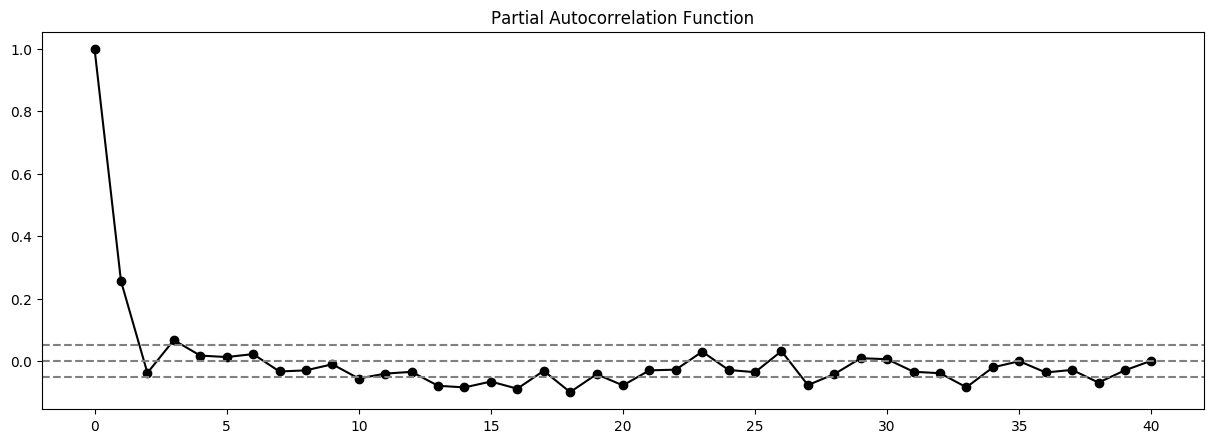

In [13]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

lag_pacf = pacf(temp_res, nlags=40)

#Plot PACF: 
plt.plot(lag_pacf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(temp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(temp_res)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function');

So, here first biggest lag above signifacance line is 1, so __p=1__.

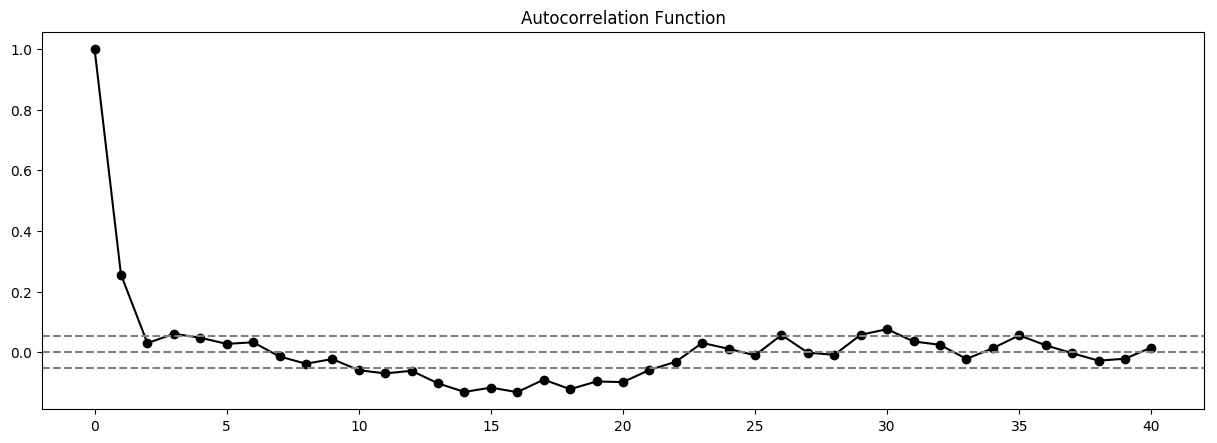

In [14]:
lag_acf = acf(temp_res, nlags=40)

#Plot ACF: 
plt.plot(lag_acf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(temp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(temp_res)),linestyle='--',color='gray')
plt.title('Autocorrelation Function');

Here, __q=1__

__Fitting model and predicting__

In [15]:
temp_model = ARIMA(temp_res, order=(1, 0, 1))
temp_model_fit = temp_model.fit(disp=-1)

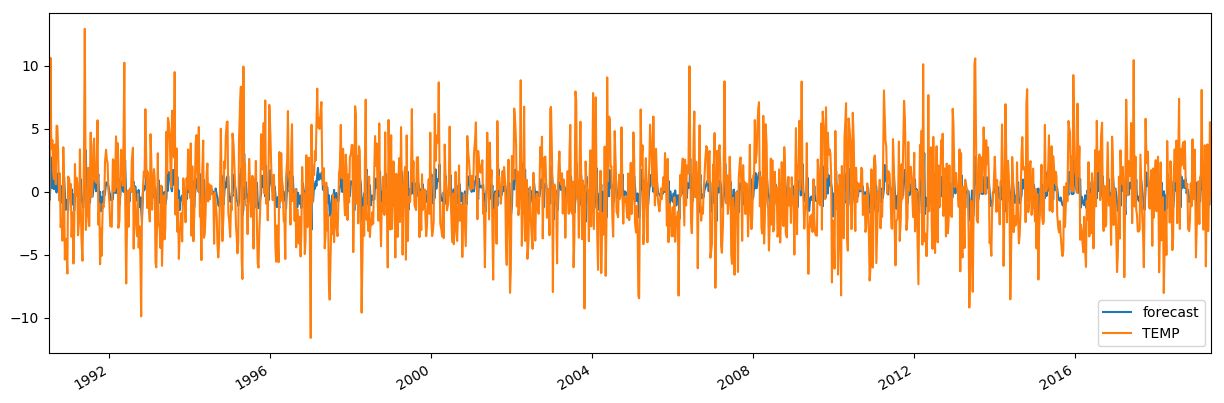

In [16]:
# Actual vs Fitted
temp_model_fit.plot_predict(dynamic=False)
plt.show()

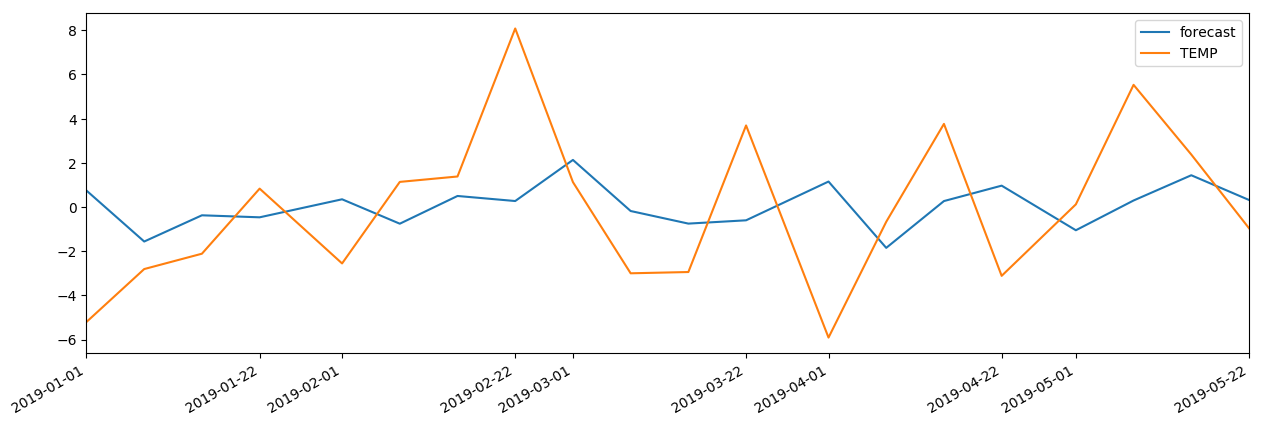

In [17]:
# only 2019 year
temp_model_fit.plot_predict(start="2019-01-01"  ,dynamic=False)
plt.show()

## Dew point

In [18]:
dewp = df.DEWP
dewp

1990-01-01    42.728571
1990-01-08    37.042857
1990-01-15    38.557143
1990-01-22    45.485714
1990-02-01    45.071429
                ...    
2019-10-22    51.228571
2019-11-01    51.342857
2019-11-08    45.671429
2019-11-15    41.925000
2019-11-22    43.564532
Name: DEWP, Length: 1436, dtype: float64

__Decomposing__

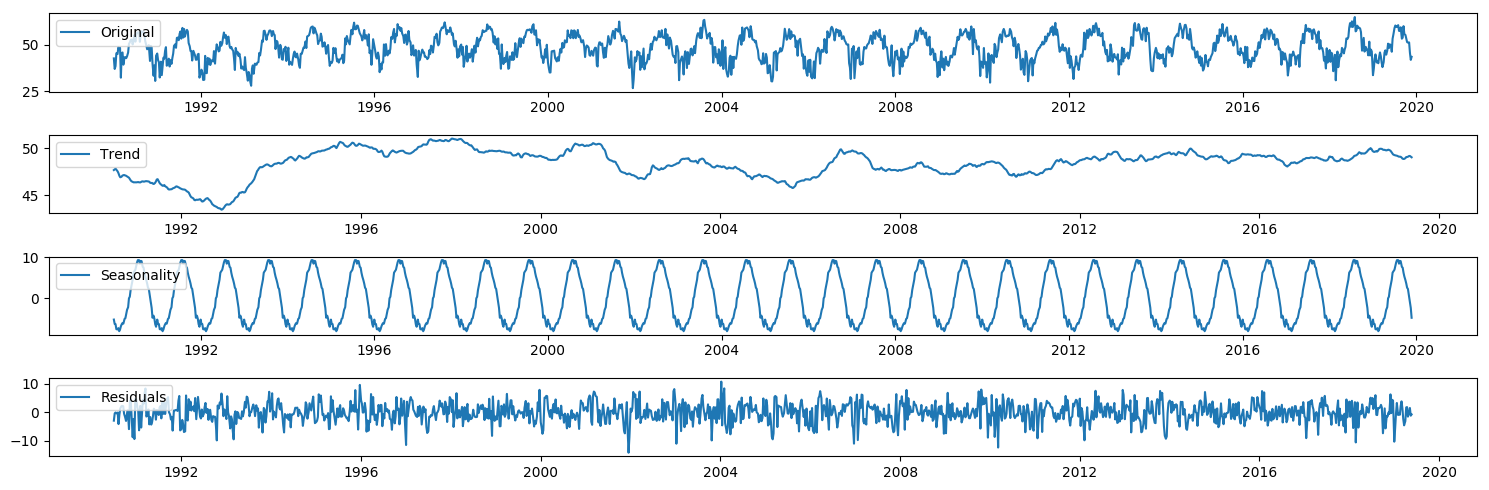

In [19]:
dewp_results = decompose(dewp, 48)
dewp_res = dewp_results[0]

In [20]:
dewp_res

1990-07-01   -2.919963
1990-07-08   -0.349735
1990-07-15   -0.041700
1990-07-22   -0.344342
1990-08-01   -0.084372
                ...   
2019-04-22   -1.506194
2019-05-01   -0.062641
2019-05-08    1.532261
2019-05-15   -1.168989
2019-05-22   -0.722764
Name: DEWP, Length: 1388, dtype: float64

In [21]:
df_test(dewp_res)

ADF Statistic: -11.545641
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Residuals for dew point is stationary now, so we can select parameters for model.

__Selecting parameters of the model__

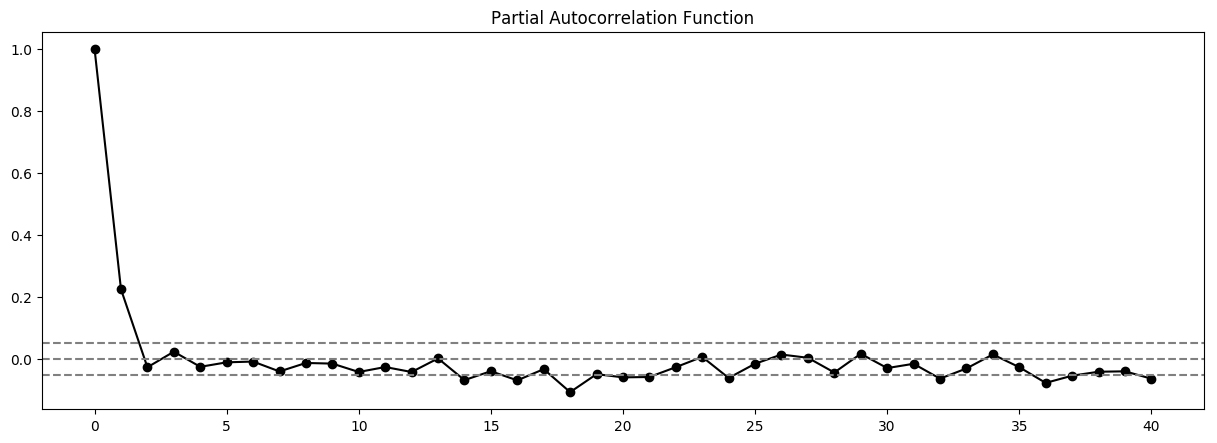

In [22]:
lag_pacf = pacf(dewp_res, nlags=40)

#Plot PACF: 
plt.plot(lag_pacf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dewp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(dewp_res)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function');

So, __p=1__.

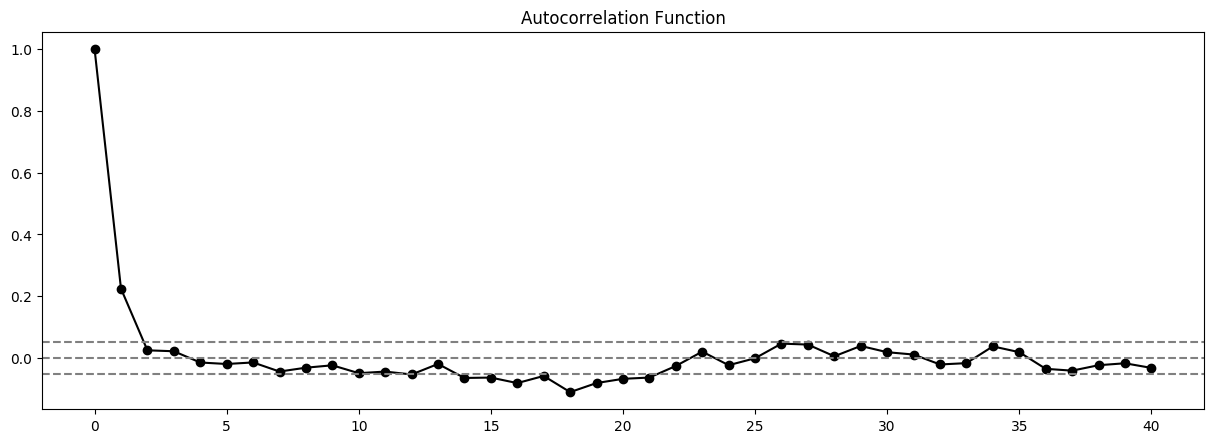

In [23]:
lag_acf = acf(dewp_res, nlags=40)

#Plot ACF: 
plt.plot(lag_acf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dewp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(dewp_res)),linestyle='--',color='gray')
plt.title('Autocorrelation Function');

__q=1__

__Fitting model and predicting__

In [24]:
dewp_model = ARIMA(dewp_res, order=(1, 0, 1))
dewp_model_fit = dewp_model.fit(disp=-1)

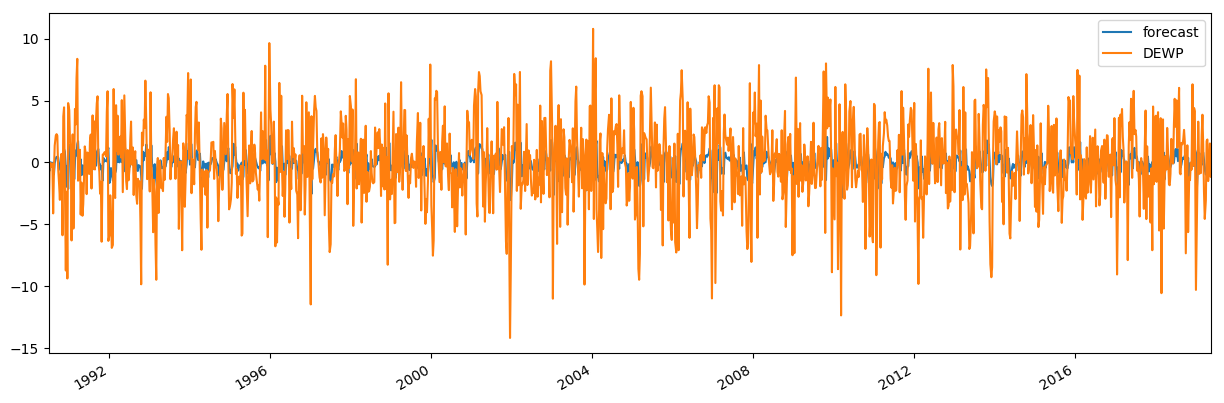

In [25]:
# Actual vs Fitted
dewp_model_fit.plot_predict(dynamic=False)
plt.show()

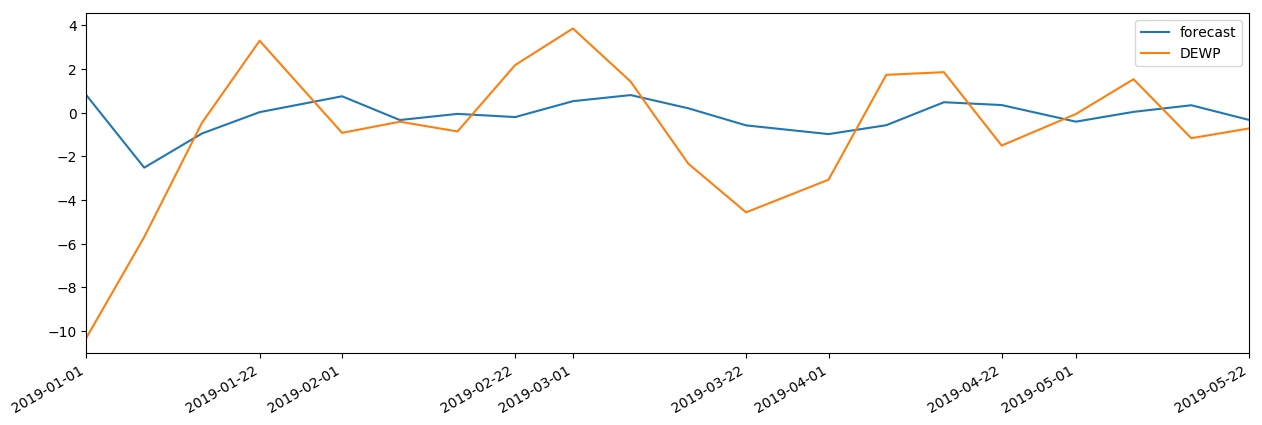

In [26]:
# only 2019 year
dewp_model_fit.plot_predict(start="2019-01-01"  ,dynamic=False)
plt.show()

## Sea level pressure

In [27]:
slp = df.SLP
slp

1990-01-01    9999.900000
1990-01-08    9999.900000
1990-01-15    9999.900000
1990-01-22    9999.900000
1990-02-01    9999.900000
                 ...     
2019-10-22    9999.900000
2019-11-01    9999.900000
2019-11-08    9999.900000
2019-11-15    9999.900000
2019-11-22    6397.700211
Name: SLP, Length: 1436, dtype: float64

__Decomposing__

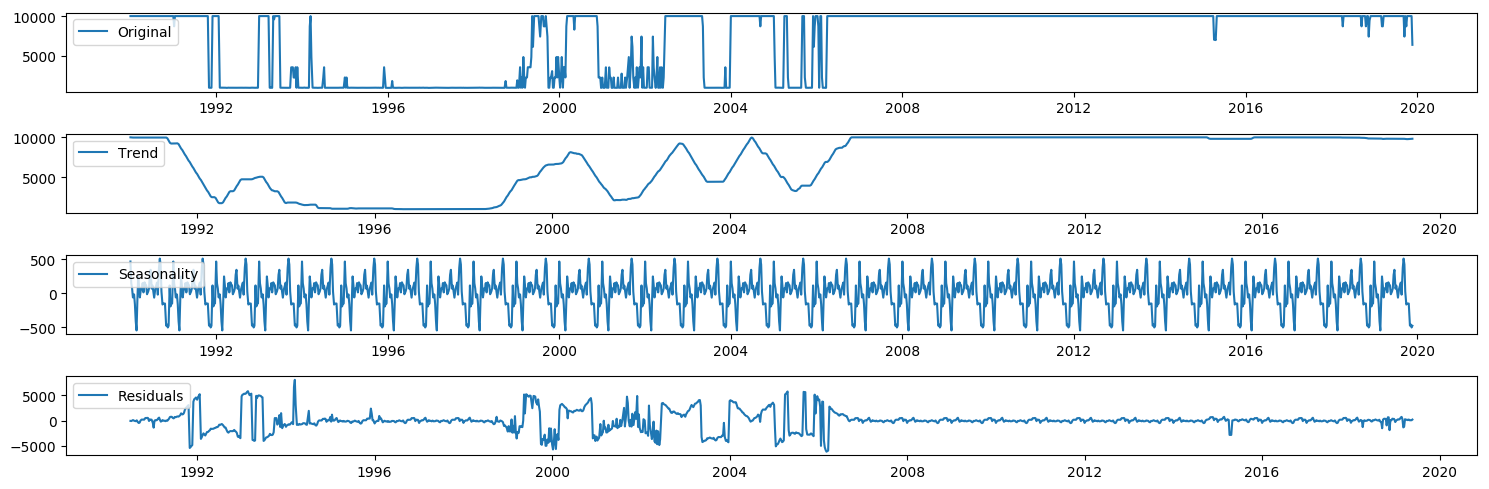

In [28]:
slp_results = decompose(slp, 48)
slp_res = slp_results[0]

In [29]:
slp_res

1990-07-01    -69.607778
1990-07-08   -100.427749
1990-07-15      1.342428
1990-07-22     90.076418
1990-08-01    -42.748705
                 ...    
2019-04-22    198.251574
2019-05-01     36.671440
2019-05-08     65.799866
2019-05-15     54.708348
2019-05-22    190.692875
Name: SLP, Length: 1388, dtype: float64

In [30]:
df_test(slp_res)

ADF Statistic: -10.226979
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Data for sea level pressure is stationaty, we can do further calculation

__Selecting parameters of the model__

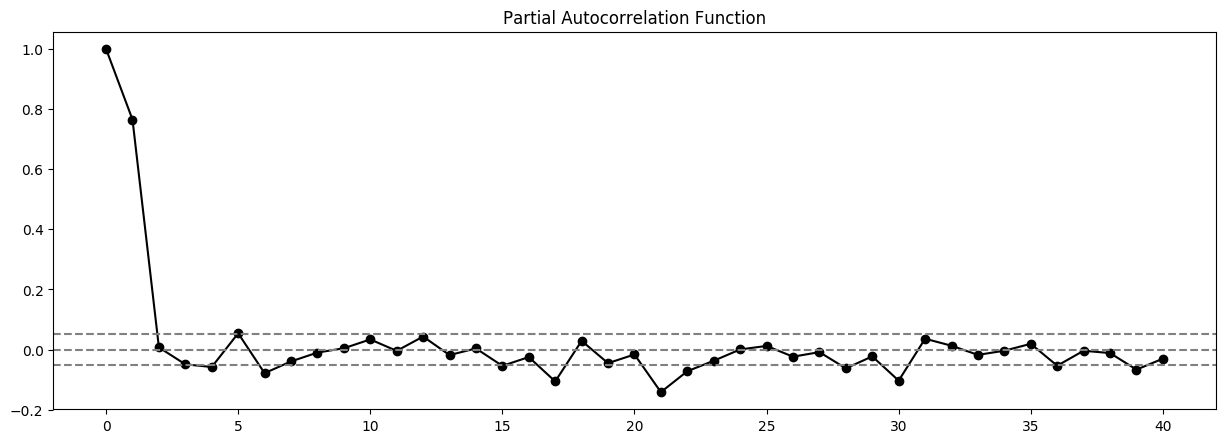

In [31]:
lag_pacf = pacf(slp_res, nlags=40)

#Plot PACF: 
plt.plot(lag_pacf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(slp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(slp_res)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function');

__p=1__

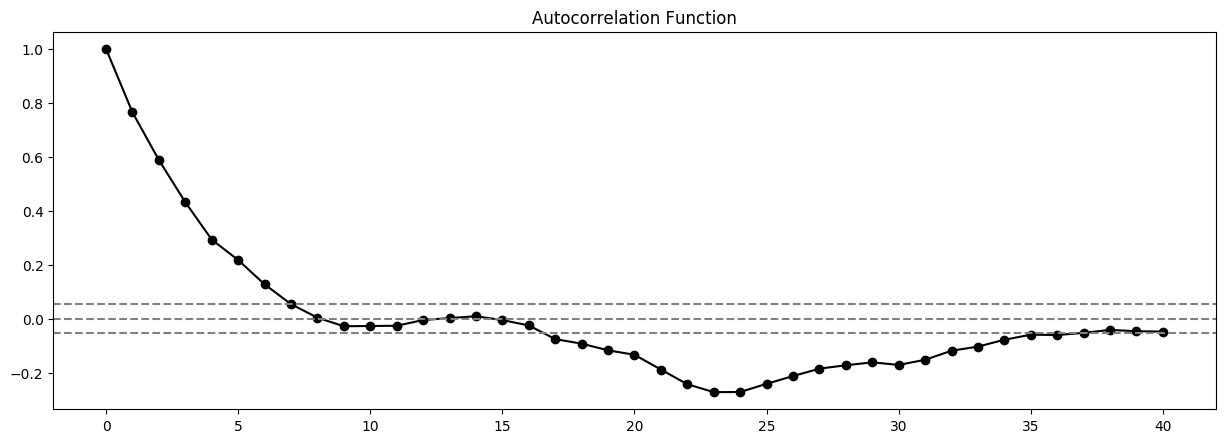

In [32]:
lag_acf = acf(slp_res, nlags=40)

#Plot ACF: 
plt.plot(lag_acf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(slp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(slp_res)),linestyle='--',color='gray')
plt.title('Autocorrelation Function');

__q=7__

__Fitting model and predicting__

In [33]:
slp_model = ARIMA(slp_res, order=(1, 0, 7))
slp_model_fit = slp_model.fit(disp=-1)

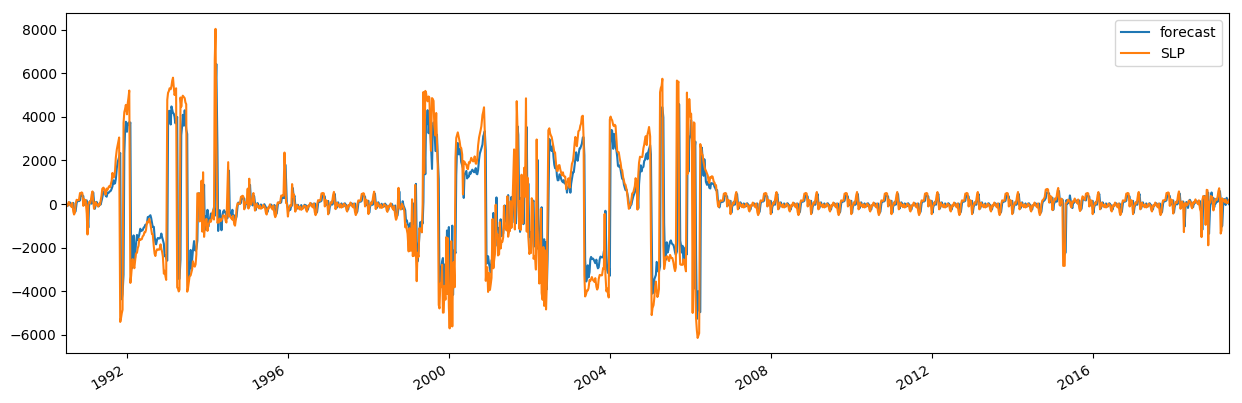

In [34]:
# Actual vs Fitted
slp_model_fit.plot_predict(dynamic=False)
plt.show()

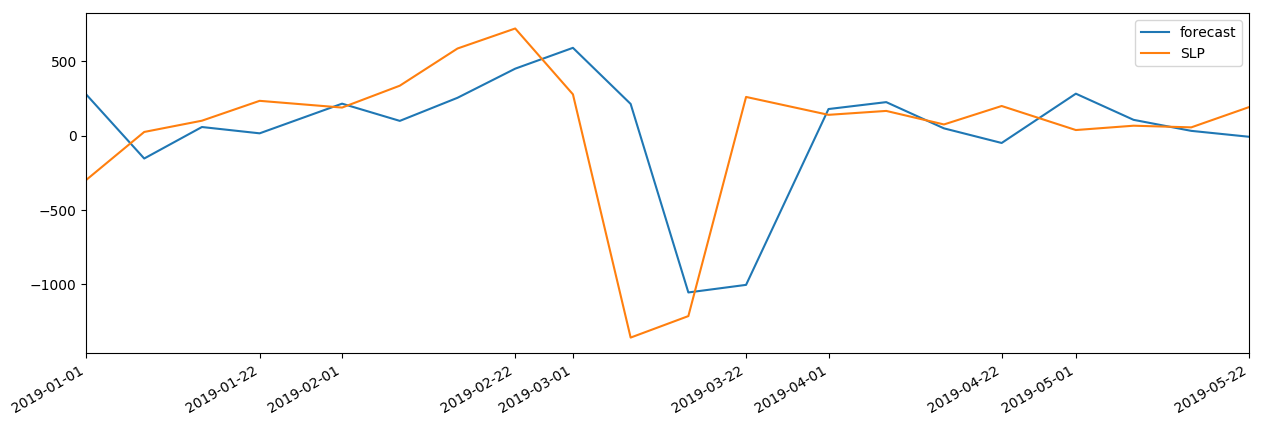

In [35]:
# only 2019 year
slp_model_fit.plot_predict(start="2019-01-01"  ,dynamic=False)
plt.show()

## Station pressure

In [36]:
stp = df.STP
stp

1990-01-01    999.900000
1990-01-08    999.900000
1990-01-15    999.900000
1990-01-22    999.900000
1990-02-01    999.900000
                 ...    
2019-10-22    999.900000
2019-11-01    999.900000
2019-11-08    999.900000
2019-11-15    999.900000
2019-11-22    990.151601
Name: STP, Length: 1436, dtype: float64

__Decomposing__

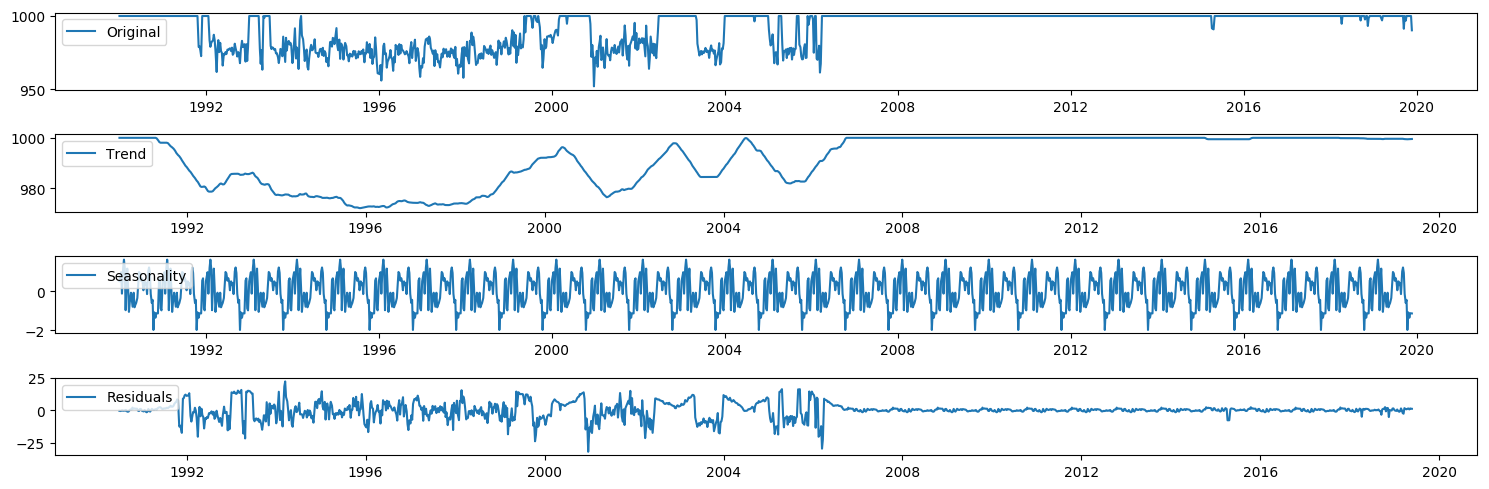

In [37]:
stp_results = decompose(stp, 48)
stp_res = stp_results[0]

In [38]:
stp_res

1990-07-01   -0.529114
1990-07-08   -0.662611
1990-07-15   -0.501528
1990-07-22   -0.046355
1990-08-01   -0.498079
                ...   
2019-04-22    1.328529
2019-05-01    0.592445
2019-05-08    1.333214
2019-05-15    1.140555
2019-05-22    1.058833
Name: STP, Length: 1388, dtype: float64

In [39]:
df_test(stp_res)

ADF Statistic: -9.977302
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Data is stationary

__Selecting parameters of the model__

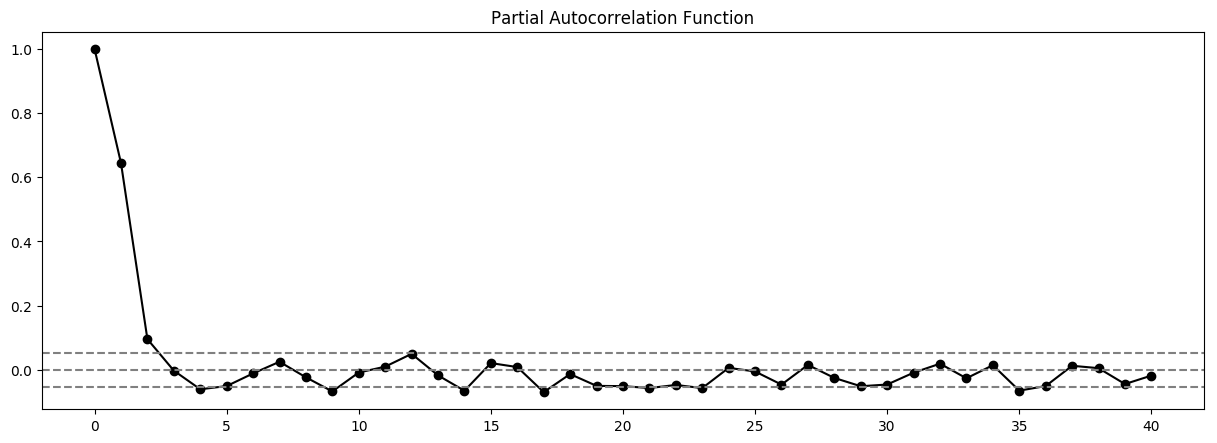

In [40]:
lag_pacf = pacf(stp_res, nlags=40)

#Plot PACF: 
plt.plot(lag_pacf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(stp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(stp_res)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function');

__p=2__

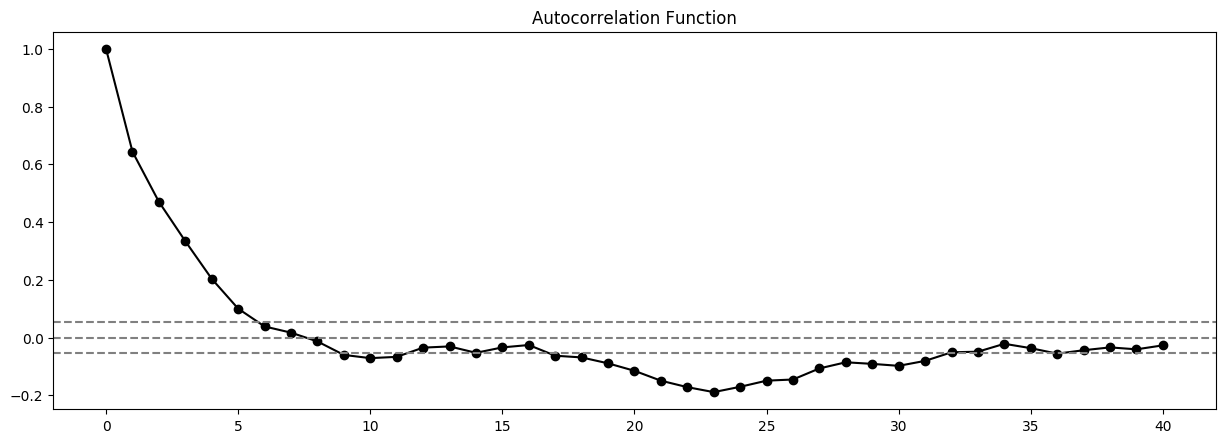

In [41]:
lag_acf = acf(stp_res, nlags=40)

#Plot ACF: 
plt.plot(lag_acf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(stp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(stp_res)),linestyle='--',color='gray')
plt.title('Autocorrelation Function');

Here looks like q can be 5, but it is better to take __q=1__.

__Fitting model and predicting__

In [42]:
stp_model = ARIMA(stp_res, order=(2, 0, 1))
stp_model_fit = stp_model.fit(disp=-1)

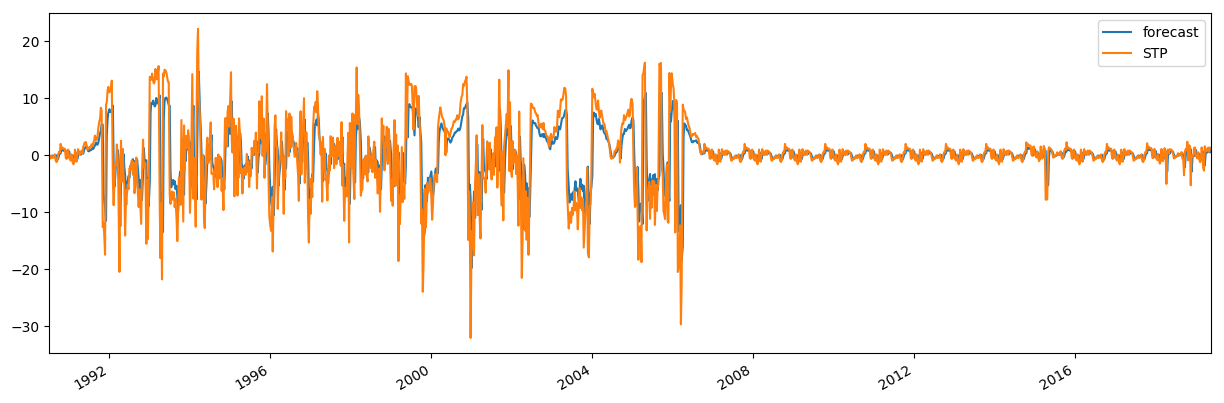

In [43]:
### Actual vs Fitted
stp_model_fit.plot_predict(dynamic=False)
plt.show()

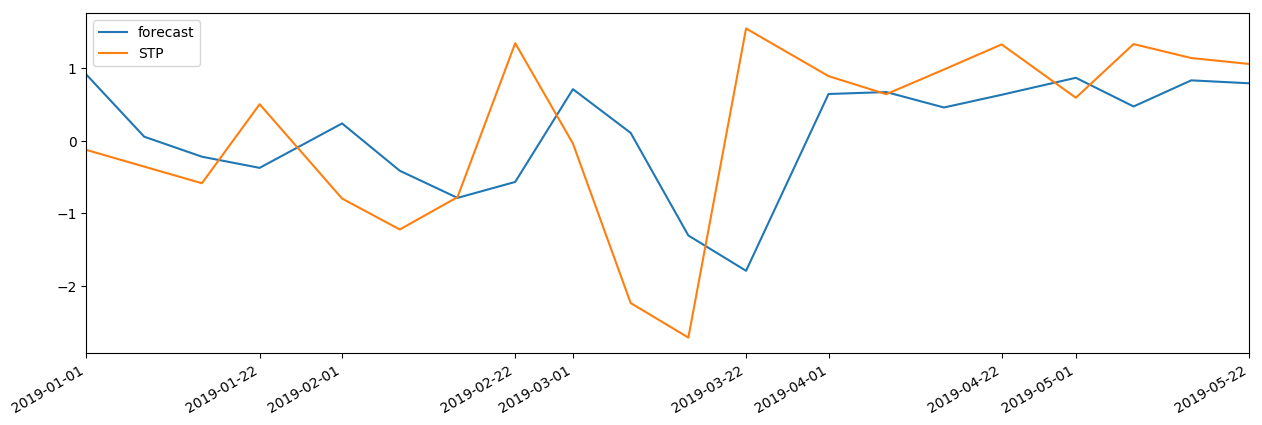

In [44]:
# only 2019 year
stp_model_fit.plot_predict(start="2019-01-01"  ,dynamic=False)
plt.show()

## Visibility

In [45]:
visib = df.VISIB
visib

1990-01-01     5.400000
1990-01-08     5.671429
1990-01-15     5.028571
1990-01-22     5.357143
1990-02-01     5.657143
                ...    
2019-10-22     6.042857
2019-11-01     5.014286
2019-11-08     4.885714
2019-11-15     5.425000
2019-11-22    20.159782
Name: VISIB, Length: 1436, dtype: float64

__Decomposing__

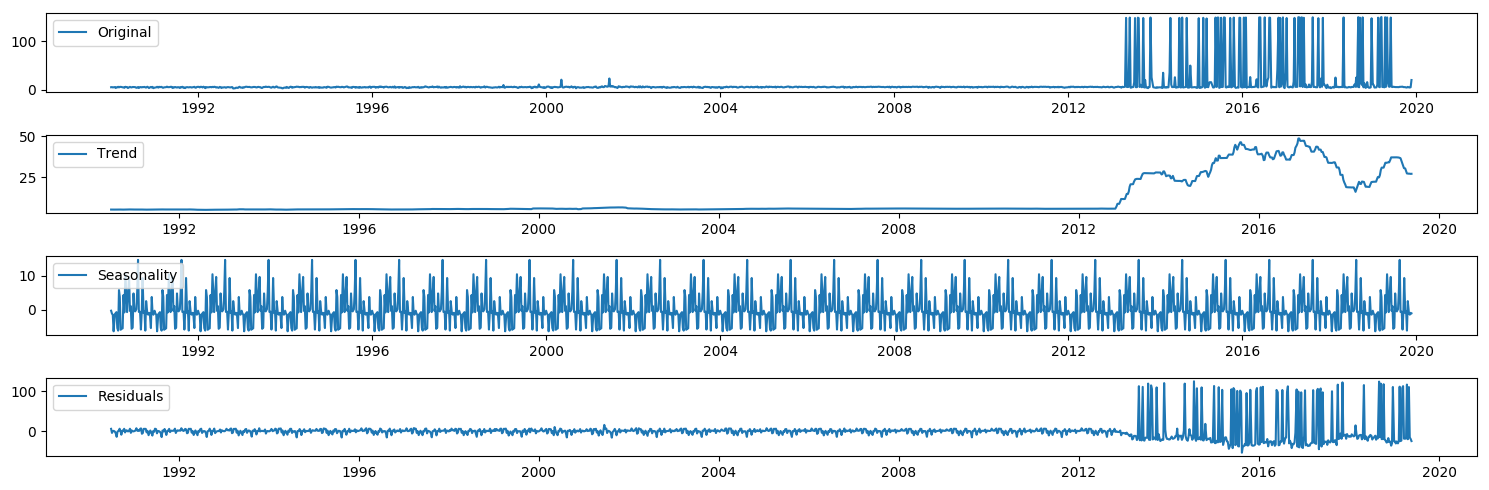

In [46]:
visib_results = decompose(visib, 48)
visib_res = visib_results[0]

In [47]:
visib_res

1990-07-01      5.909158
1990-07-08     -4.310579
1990-07-15      0.323966
1990-07-22      0.906772
1990-08-01     -1.218828
                 ...    
2019-04-22    -20.179588
2019-05-01    110.805778
2019-05-08    -15.739389
2019-05-15    -19.325082
2019-05-22    -24.791396
Name: VISIB, Length: 1388, dtype: float64

In [48]:
df_test(visib_res)

ADF Statistic: -9.124287
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Visibility data is stationary

__Selecting parameters of the model__

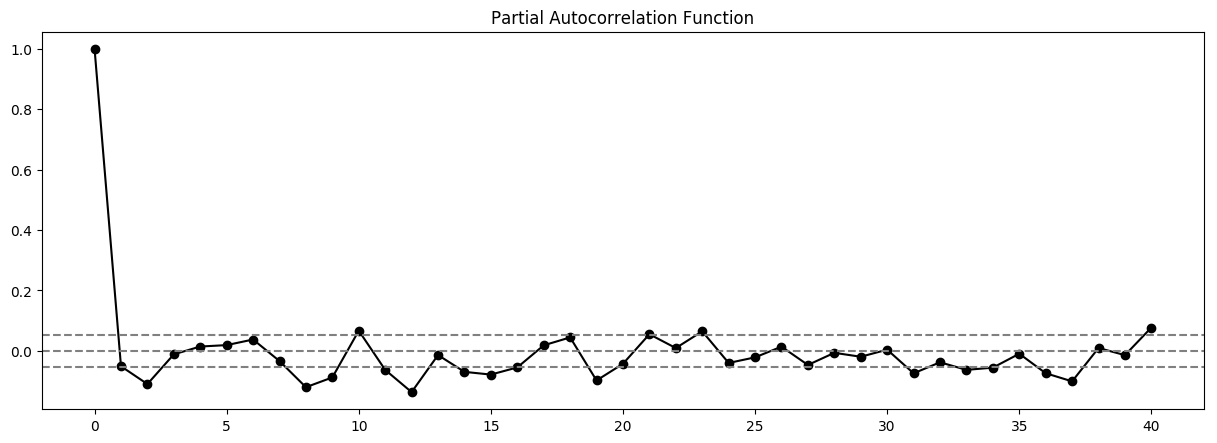

In [49]:
lag_pacf = pacf(visib_res, nlags=40)

#Plot PACF: 
plt.plot(lag_pacf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(visib_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(visib_res)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function');

__p=1__

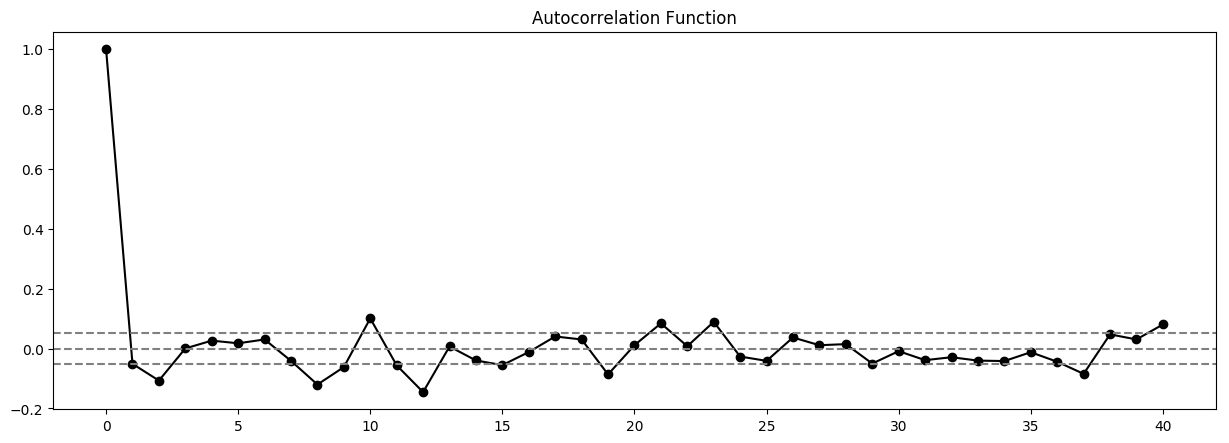

In [50]:
lag_acf = acf(visib_res, nlags=40)

#Plot ACF: 
plt.plot(lag_acf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(visib_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(visib_res)),linestyle='--',color='gray')
plt.title('Autocorrelation Function');

__q=1__

__Fitting model and predicting__

In [51]:
visib_model = ARIMA(visib_res, order=(3, 0, 3))
visib_model_fit = visib_model.fit(disp=-1)

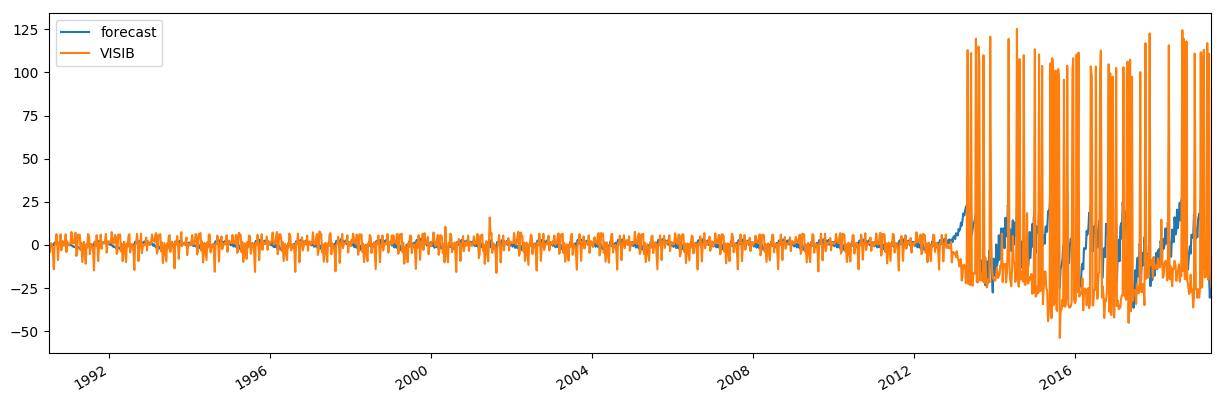

In [52]:
# Actual vs Fitted
visib_model_fit.plot_predict(dynamic=False)
plt.show()

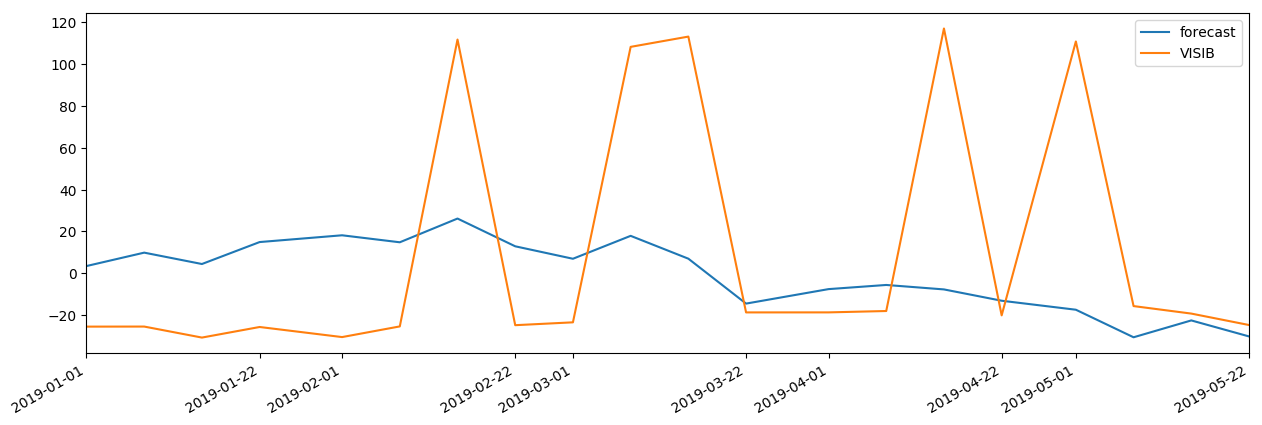

In [53]:
# only 2019 year
visib_model_fit.plot_predict(start="2019-01-01"  ,dynamic=False)
plt.show()

## Wind speed

In [54]:
wdsp = df.WDSP
wdsp

1990-01-01     6.042857
1990-01-08     3.071429
1990-01-15     3.914286
1990-01-22     9.385714
1990-02-01    12.257143
                ...    
2019-10-22     5.985714
2019-11-01     7.428571
2019-11-08     5.785714
2019-11-15     4.075000
2019-11-22     5.757143
Name: WDSP, Length: 1436, dtype: float64

__Decomposition__

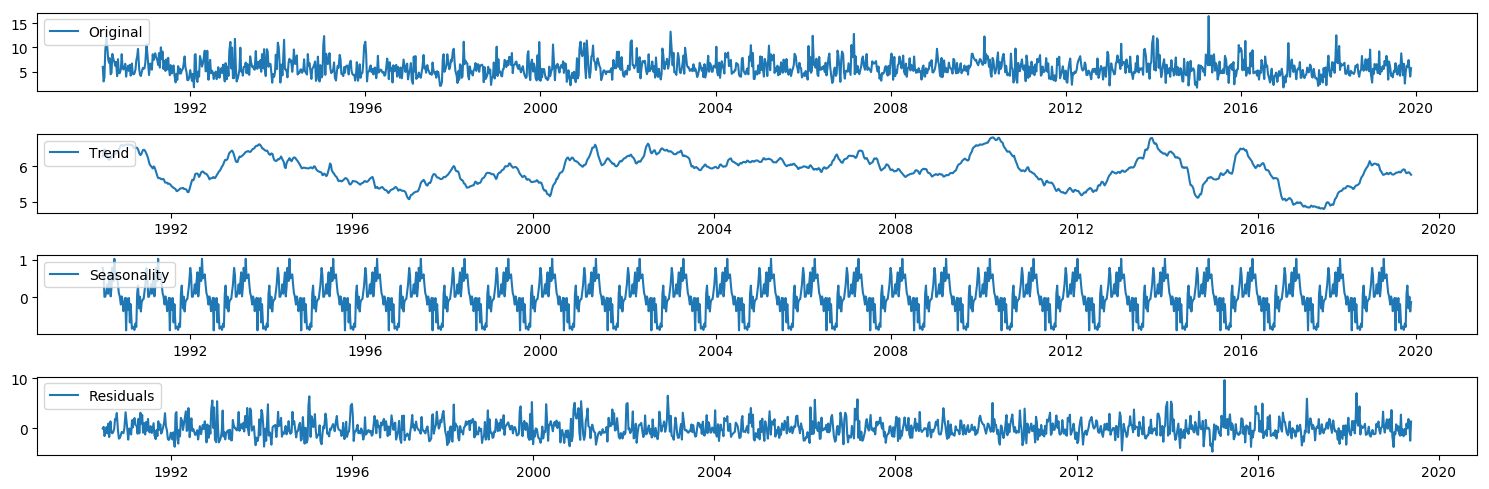

In [55]:
wdsp_results = decompose(wdsp, 48)
wdsp_res = wdsp_results[0]

In [56]:
wdsp_res

1990-07-01   -0.028552
1990-07-08    0.302652
1990-07-15   -1.539620
1990-07-22   -0.858606
1990-08-01    0.286730
                ...   
2019-04-22   -0.019100
2019-05-01    1.842841
2019-05-08    0.951998
2019-05-15   -2.466019
2019-05-22    1.349544
Name: WDSP, Length: 1388, dtype: float64

In [57]:
df_test(wdsp_res)

ADF Statistic: -13.275749
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Wind speed data is stationary now

__Selecting parameters of the model__

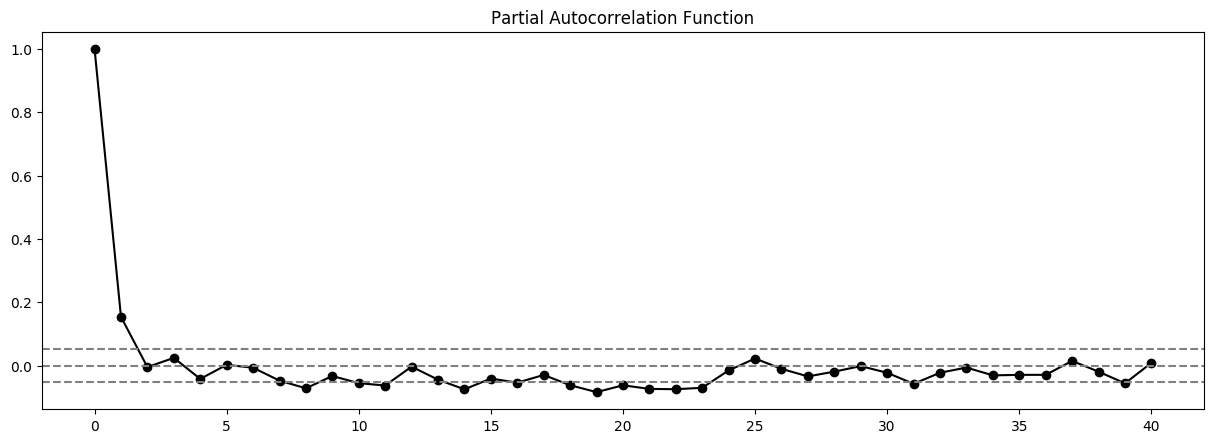

In [58]:
lag_pacf = pacf(wdsp_res, nlags=40)

#Plot PACF: 
plt.plot(lag_pacf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(wdsp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(wdsp_res)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function');

__p=1__

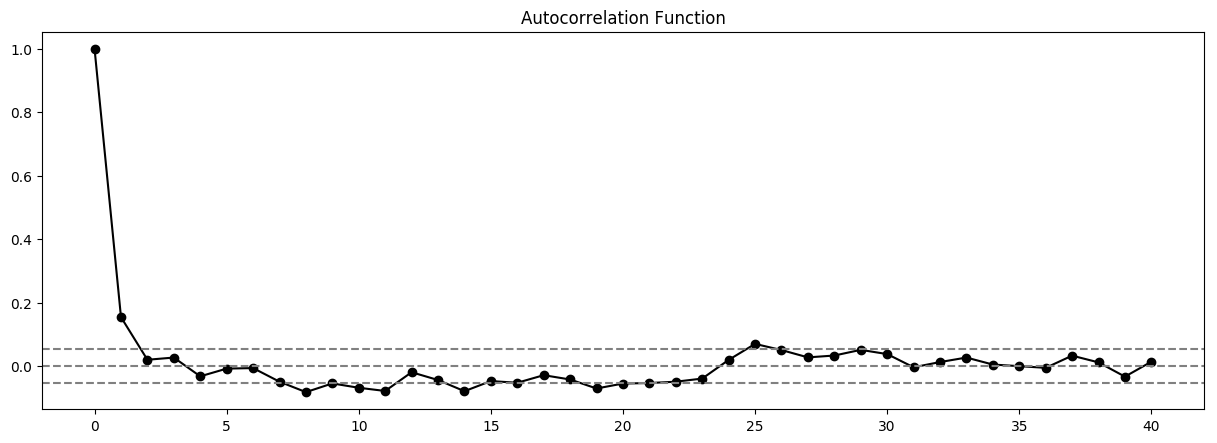

In [59]:
lag_acf = acf(wdsp_res, nlags=40)

#Plot ACF: 
plt.plot(lag_acf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(wdsp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(wdsp_res)),linestyle='--',color='gray')
plt.title('Autocorrelation Function');

Here we can not take q=3, so q=1 is an optimal one

__Fitting model and predicting__

In [60]:
wdsp_model = ARIMA(wdsp_res, order=(1, 0, 1))
wdsp_model_fit = wdsp_model.fit(disp=-1)

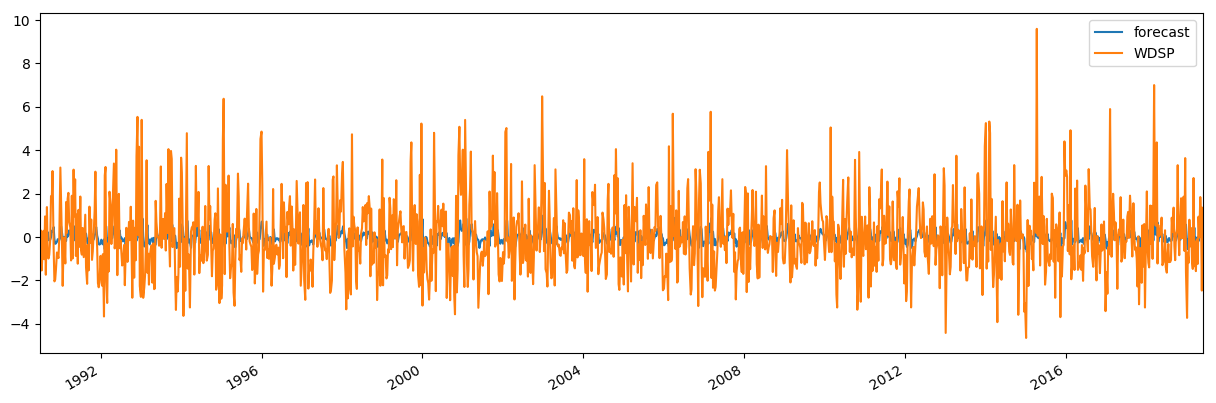

In [61]:
# Actual vs Fitted
wdsp_model_fit.plot_predict(dynamic=False)
plt.show()

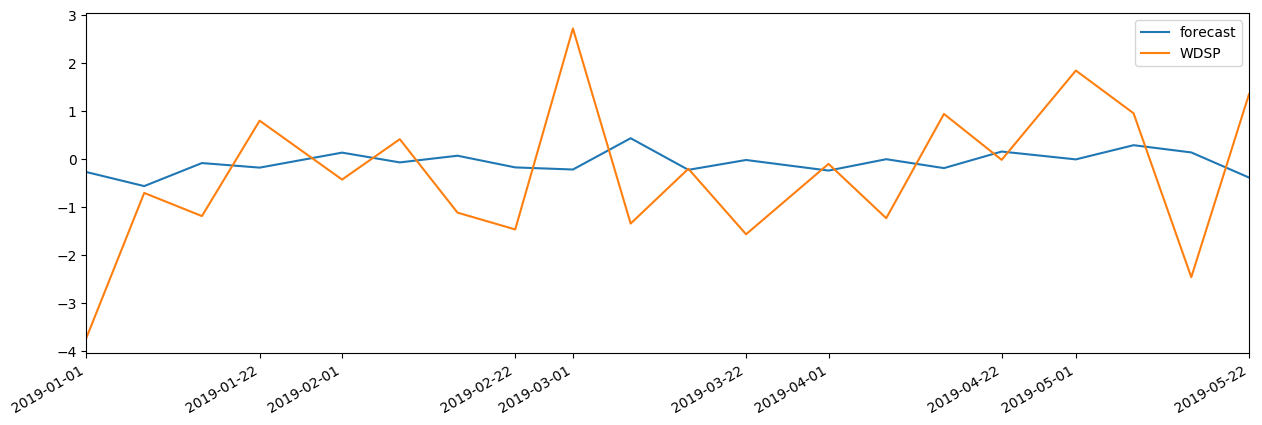

In [62]:
# only 2019 year
wdsp_model_fit.plot_predict(start="2019-01-01"  ,dynamic=False)
plt.show()

## Precipitation amount

In [63]:
prcp = df.PRCP
prcp

1990-01-01    0.268571
1990-01-08    0.002857
1990-01-15    0.004286
1990-01-22    0.375714
1990-02-01    0.500000
                ...   
2019-10-22    0.098571
2019-11-01    0.540000
2019-11-08    0.437143
2019-11-15    0.427500
2019-11-22    0.218441
Name: PRCP, Length: 1436, dtype: float64

__Decomposition__

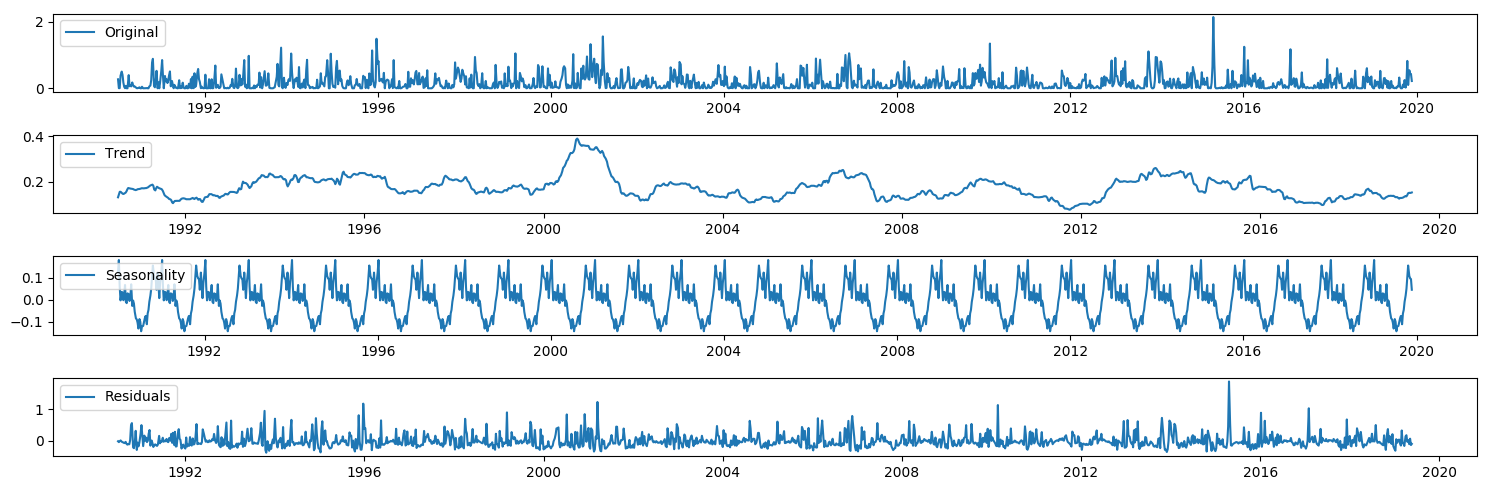

In [64]:
prcp_results = decompose(prcp, 48)
prcp_res = prcp_results[0]

In [65]:
prcp_res

1990-07-01   -0.014617
1990-07-08   -0.041853
1990-07-15   -0.012068
1990-07-22    0.011654
1990-08-01   -0.030910
                ...   
2019-04-22    0.023788
2019-05-01   -0.107074
2019-05-08    0.066209
2019-05-15   -0.133536
2019-05-22   -0.097318
Name: PRCP, Length: 1388, dtype: float64

In [66]:
df_test(prcp_res)

ADF Statistic: -12.203727
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Percipitations are also stationary

__Selecting parameters of the model__

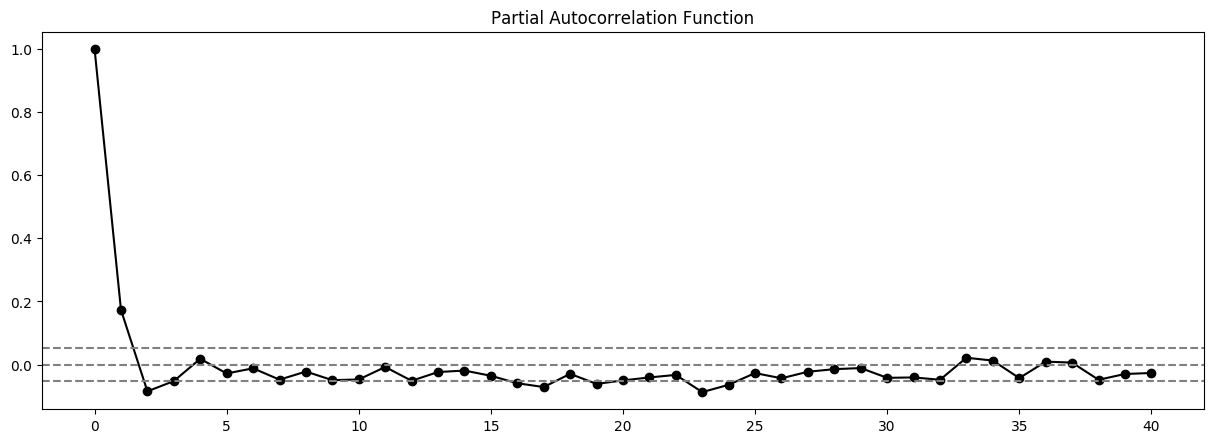

In [67]:
lag_pacf = pacf(prcp_res, nlags=40)

#Plot PACF: 
plt.plot(lag_pacf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(prcp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(prcp_res)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function');

__p=2__

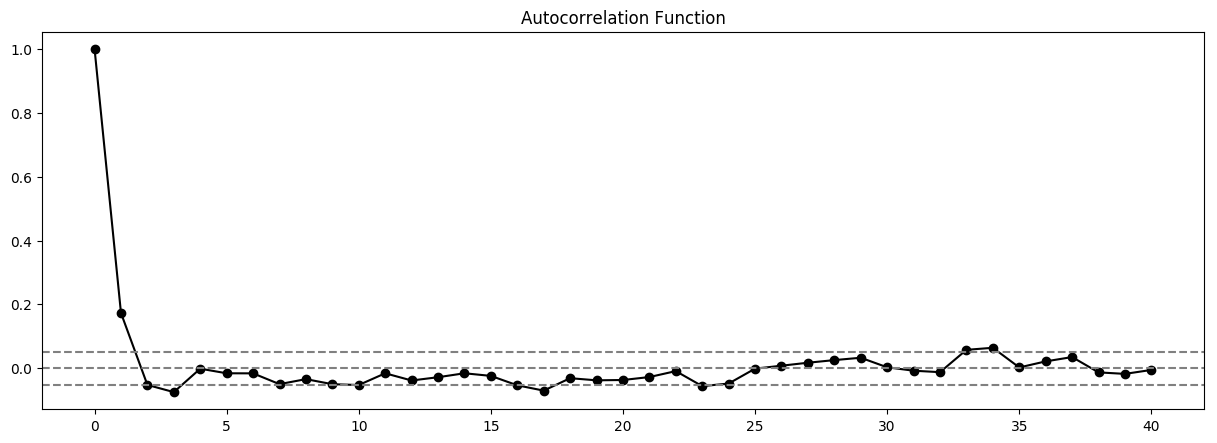

In [68]:
lag_acf = acf(prcp_res, nlags=40)

#Plot ACF: 
plt.plot(lag_acf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(prcp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(prcp_res)),linestyle='--',color='gray')
plt.title('Autocorrelation Function');

__q=2__

Here, we should take p=0 and q=0, but then model predicts just straight line. Taking 2 as parameters yields in much more realistic prediction

__Fitting model and predicting__

In [69]:
prcp_model = ARIMA(prcp_res, order=(1, 0, 1))
prcp_model_fit = prcp_model.fit(disp=-1)

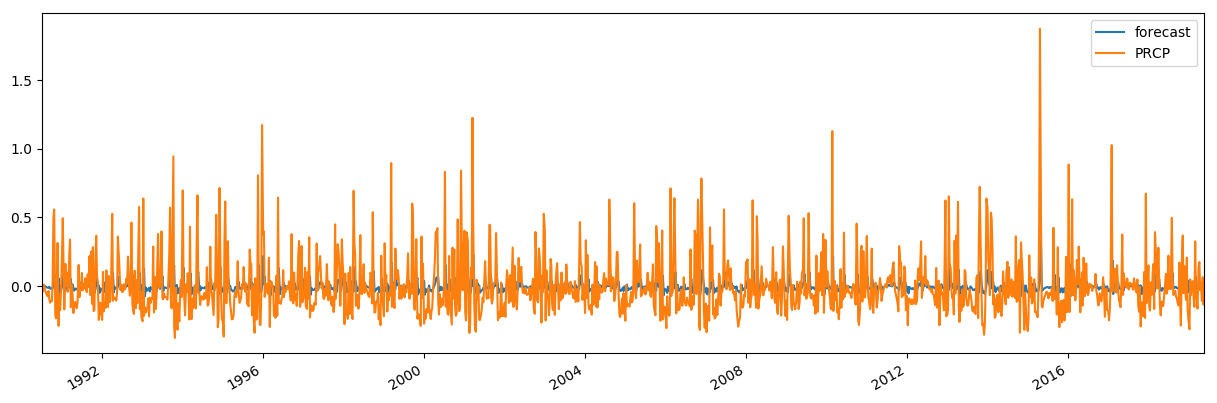

In [70]:
# Actual vs Fitted
prcp_model_fit.plot_predict(dynamic=False)
plt.show()

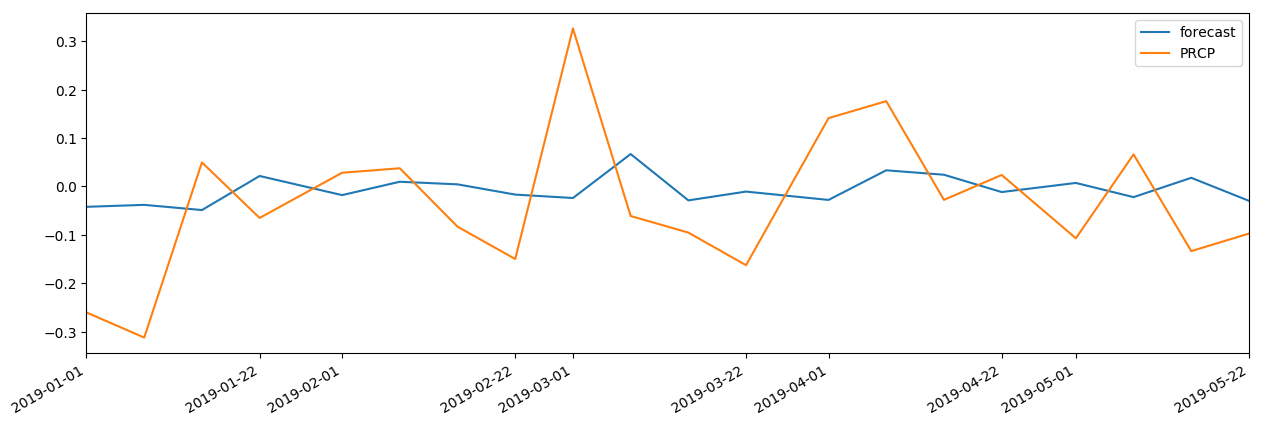

In [71]:
# only 2019 year
prcp_model_fit.plot_predict(start="2019-01-01"  ,dynamic=False)
plt.show()

# Results evaluation

Here, I'll demonstrate how much my prediction differce from real weather data.

In [72]:
from sklearn.metrics import mean_squared_error

def plot_results(original, model_fit, decom_results):
    
    forecast = model_fit.predict(start="2019-01-01")
    trend = decom_results[1].loc["2019-01-01":"2019-05-23",]
    season = decom_results[2].loc["2019-01-01":"2019-05-23",]
    
    predicted = forecast + trend + season
    
    months = sorted(list({str(date)[5:7] for date in original.index}))
    
    predicted_results, original_results = [], []
    
    for month in months:
        or_total, pred_total = 0, 0
        c = 0
        for indx in original.index:
            if str(indx)[5:7] == month:
                or_total += original[indx]
                pred_total += predicted[indx]
                c += 1
        predicted_results.append(pred_total / c)
        original_results.append(or_total / c)
        
    results = pd.DataFrame(data={'Real':original_results, 'Predicted':predicted_results}, 
                           index=months)
    
    print("RMSE:{}\n\n".format(mean_squared_error(original, predicted)**0.5))
                
    plt.plot(original)
    plt.plot(predicted)
    plt.legend(["Original", "Predicted"], loc='upper left')
    plt.show()
    
    
    return results

### Temperature

RMSE:3.599461910740345




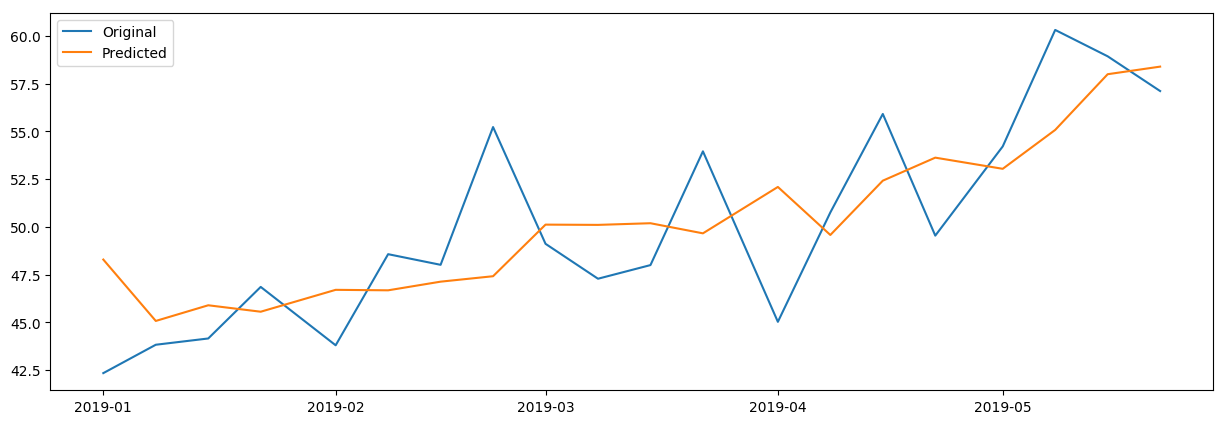

,Real,Predicted
01,44.296429,46.204632
02,48.903571,46.983059
03,49.589286,50.019806
04,50.310714,51.929076
05,57.644048,56.127236


In [73]:
plot_results(temp.loc["2019-01-01":"2019-05-23",], temp_model_fit, temp_results)

### Dew point

RMSE:3.2167592058705115




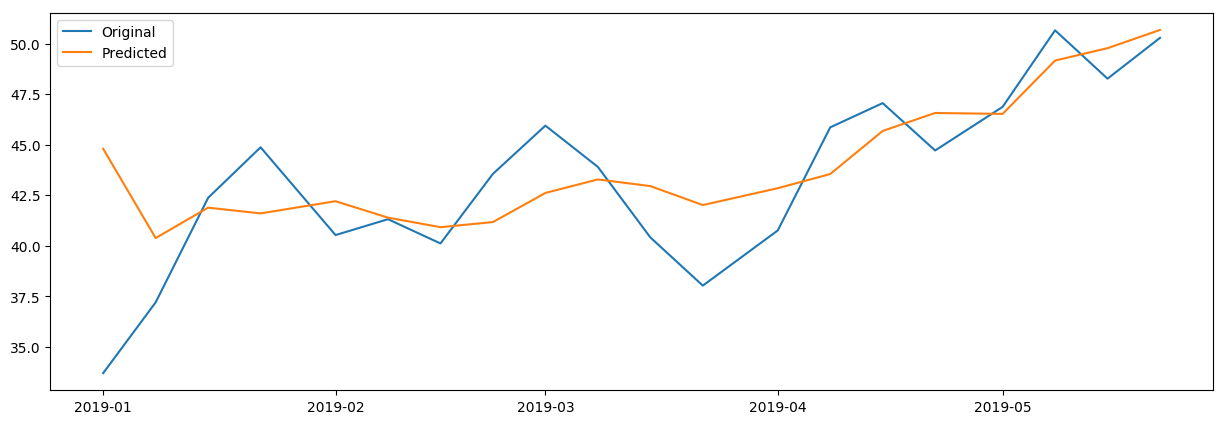

,Real,Predicted
01,39.535714,42.166023
02,41.378571,41.422012
03,42.071429,42.714855
04,44.596429,44.661373
05,49.020238,49.034480


In [74]:
plot_results(dewp.loc["2019-01-01":"2019-05-23",], dewp_model_fit, dewp_results)

### Sea level pressure

RMSE:499.84313655815436




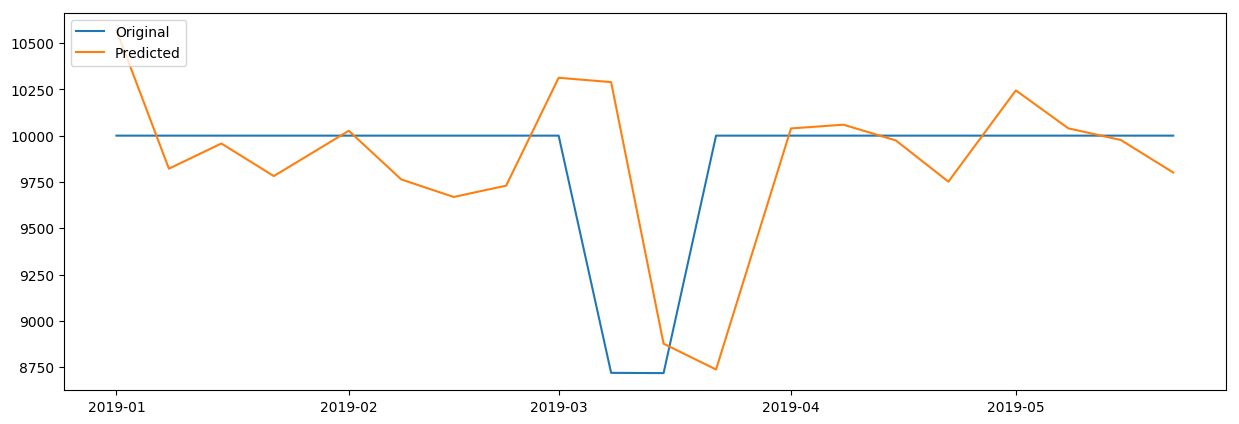

,Real,Predicted
01,9999.900000,10032.762261
02,9999.900000,9797.075485
03,9359.128571,9553.726203
04,9999.900000,9955.725815
05,9999.900000,10015.179187


In [75]:
plot_results(slp.loc["2019-01-01":"2019-05-23",], slp_model_fit, slp_results)

### Station pressure

RMSE:1.1958957866055469




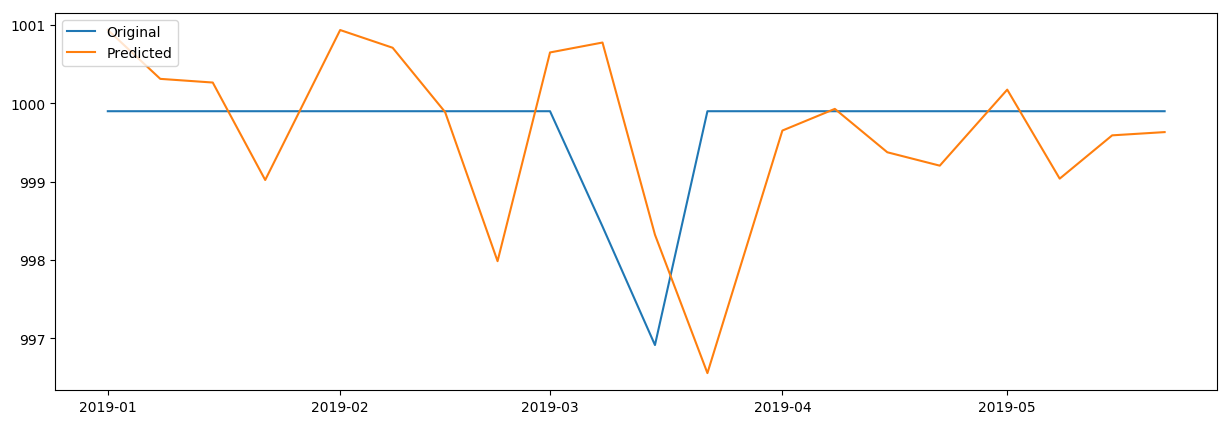

,Real,Predicted
01,999.900000,1000.134740
02,999.900000,999.880445
03,998.785714,999.076578
04,999.900000,999.540862
05,999.900000,999.609917


In [76]:
plot_results(stp.loc["2019-01-01":"2019-05-23",], stp_model_fit, stp_results)

### Visibility

RMSE:59.46598190902946




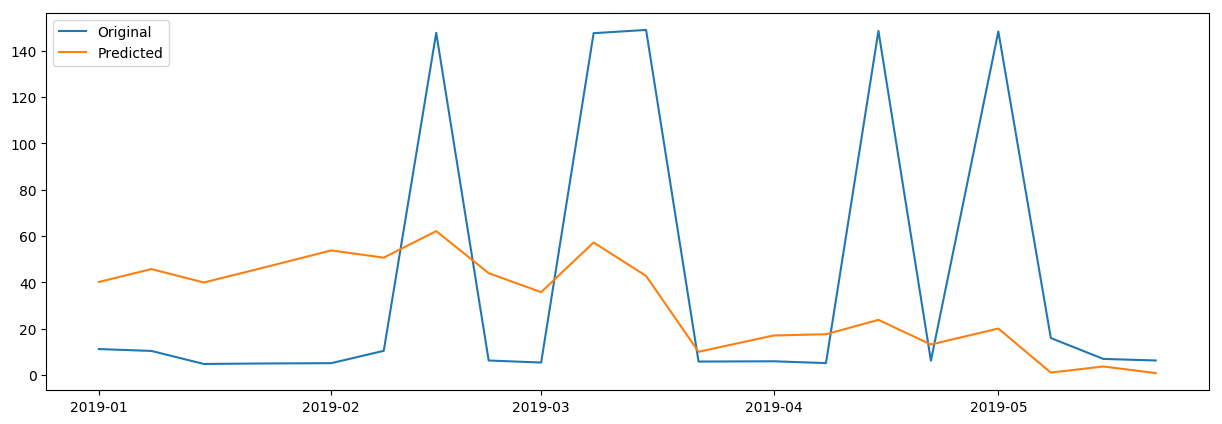

,Real,Predicted
01,7.846017,42.875338
02,42.406612,52.665210
03,76.962192,36.470896
04,41.471429,17.922503
05,44.395105,6.413666


In [77]:
plot_results(visib.loc["2019-01-01":"2019-05-23",], visib_model_fit, visib_results)

### Wind Speed

RMSE:1.5565724956391258




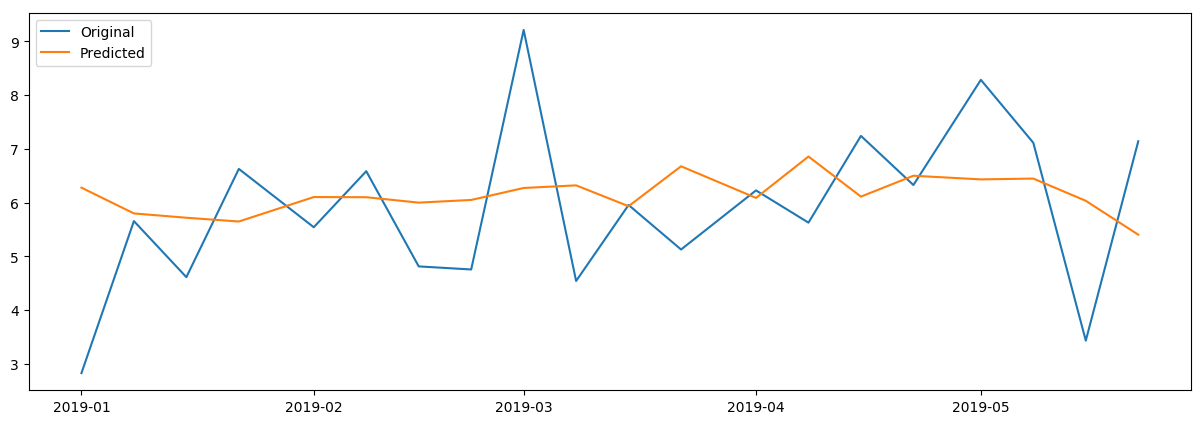

,Real,Predicted
01,4.932143,5.862266
02,5.425000,6.064539
03,6.210714,6.301824
04,6.357143,6.390360
05,6.494048,6.080353


In [78]:
plot_results(wdsp.loc["2019-01-01":"2019-05-23",], wdsp_model_fit, wdsp_results)

### Precipitation amount

RMSE:0.14766377890559518




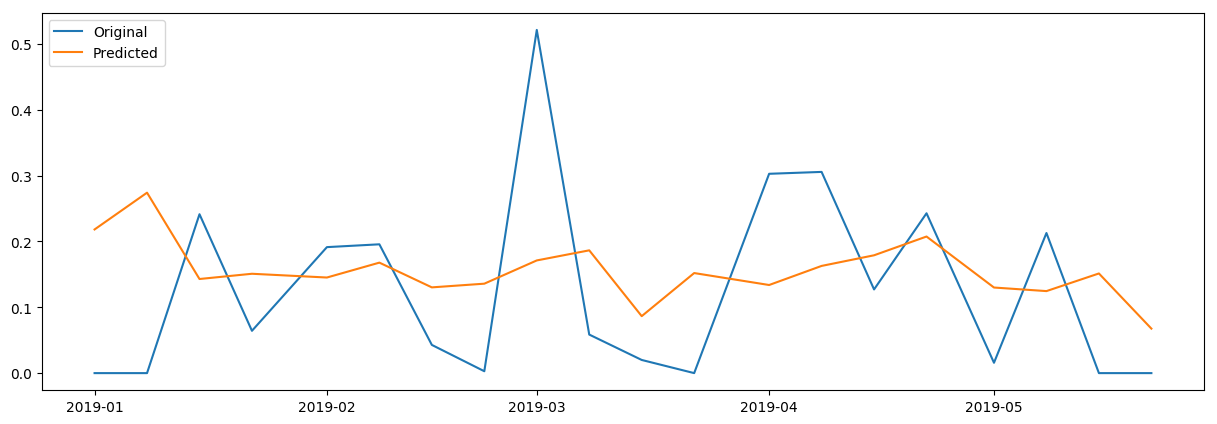

,Real,Predicted
01,0.076429,0.196600
02,0.108214,0.144824
03,0.150000,0.149092
04,0.244643,0.170829
05,0.057143,0.118426


In [79]:
plot_results(prcp.loc["2019-01-01":"2019-05-23",], prcp_model_fit, prcp_results)